# Configurações

Imports de Pacotes

In [1]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

Funções úteis

In [2]:
def take_photo(filename='photo.jpg', quality=0.6):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Informações do cliente

In [3]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Fabio Rizzi" #@param {type:"string"}
renda = 10000 #@param {type:"number"}
idade = 36 #@param {type:"slider", min:18, max:100, step:1}
etnia = "0"  #@param ["Selecionar", "0", "1"]
genero = "Masculino" #@param ["Selecionar", "Masculino", "Feminino"]
casa_propria = "Nao" #@param ["Selecionar", "Sim", "Nao"]
outras_rendas = "N\xE3o" #@param ["Selecionar", "Sim", "Não"]
estado_civil = "Solteiro" #@param ["Selecionar", "Solteiro", "Casado"]
escolaridade = 1 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---

sexo = [0 if genero == "Masculino" else 1]
casapropria = [0 if casa_propria == "Nao" else 1]
outrasrendas = [0 if outras_rendas == "Nao" else 1]
estadocivil = [0 if estado_civil == "Solteiro" else 1]

raw_data = {"nome":  { "0": str(nome) },
            "renda": { "0": str(renda)},
            "idade": { "0": str(idade)},
            "etnia": { "0": str(etnia)},
            "sexo":  { "0": str(sexo[0])},
            "casapropria": { "0": str(casapropria[0])},
            "outrasrendas": { "0": str(outrasrendas[0])},
            "escolaridade": { "0": str(escolaridade)}
            }

import pandas as pd
perfil = pd.DataFrame(raw_data).to_json()
perfil = pd.read_json(perfil)
perfil = perfil.to_json()

<IPython.core.display.Javascript object>

Saved to photo.jpg


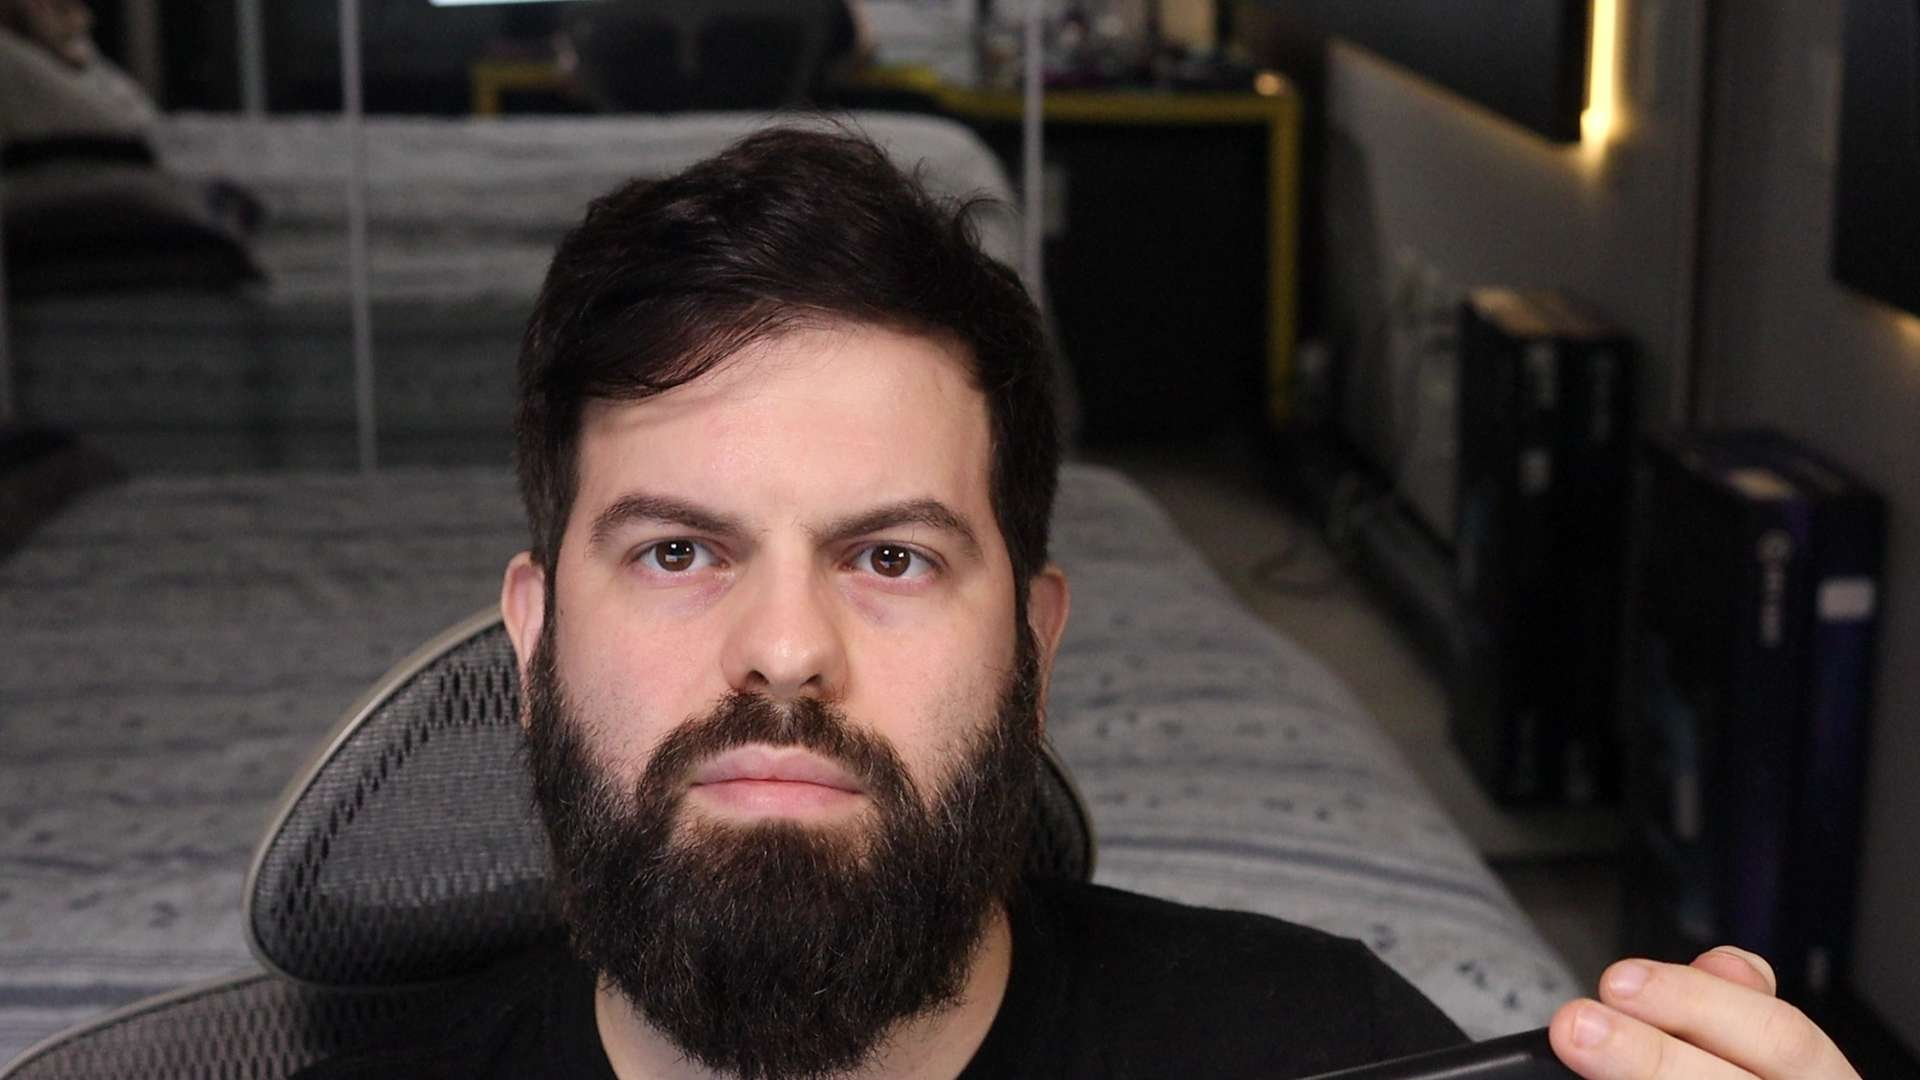

In [4]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Análise de crédito

1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.


2.  Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.  


3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos), informar mensagem e não conceder o empréstimo.


4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure. (em uma aplicação corporativa, estes pontos ficam gravados para futuras autenticações)


5. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud. Esta API deve usar os dados informados neste notebook e **automaticamente** vetar ou conceder o empréstimo.


ATENÇÃO PARA O BULLET 5: É necessário chamar tanto um modelo que possua a variável ETNIA quanto um modelo que não possui esta variável, assim como fizemos em aula!!!


6. Gravar um vídeo "operando" o notebook e simulando a avaliação com concessão ou reprovação do crédito.


7. Submeter o Notebook e o vídeo da plataforma da FIAP, se o vídeo ficar muito grande, submeter ao Youtube (pode ser privado) e anexar o Link.

---  
(Dica: Você pode usar este vídeo para divulgar seu trabalho como Engenheiro de ML)


Solução
-------

In [5]:
# !pip install ibm-watson watson-developer-cloud

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# IBM Cloud
import os
import json
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

ibmkey = {
    "apikey": "",
    "url": ""
}

# Open credentials file
if os.path.exists('/content/drive/MyDrive/PlataformasCognitivas/ibmkey.json'):
    with open('/content/drive/MyDrive/PlataformasCognitivas/ibmkey.json') as json_file:
        ibmkey = json.load(json_file)

# IBM visual recognition service
authenticator = IAMAuthenticator(ibmkey["apikey"])
visual_recognition = VisualRecognitionV3(version='2018-03-19', authenticator=authenticator)
visual_recognition.set_service_url(ibmkey["url"])

VERBOSE = None
DEBUG = None

def classify_image(photo, classifier_id):
  with open(photo, 'rb') as image_file:
    response = visual_recognition.classify(images_file=image_file,
                                           images_filename="temp",
                                           threshold=0.6,
                                           classifier_ids=classifier_id).get_result()
    return json.dumps(response)

# 1. Retorna True se for detectado como "person" com score acima  do threshold
#    definido, senão, retorna False.
def is_person(photo):
  threshold = 0.6
  score = 0
  json_object = json.loads(classify_image(photo,"default"))
  mydict = json_object['images'][0]['classifiers'][0]['classes']
  if DEBUG == True:
    print("1. (DEBUG) begin is_person:")
    print(json.dumps(mydict, indent=2))
    print("1. (DEBUG) end is_person")
  for current_object in mydict:
    if current_object['class'] == 'person':
      score = current_object['score']
      if score > threshold:
        if VERBOSE == True: print("1. Pessoa detectada. Score: {:.2%}".format(score))
        return True
  print("1. Pessoa não detectada.")
  return False # Nao encontrou classe 'person' ou foi abaixo do threshold.

# 2. Retorna True se imagem não for explícita e False se tiver conteúdo
#    explícito
def not_explicit(photo):
  threshold = 0.7
  json_object = json.loads(classify_image(photo,"explicit"))
  if DEBUG == True:
    print("2. (DEBUG) begin not_explicit:")
    print(json.dumps(json_object, indent=2))
    print("2. (DEBUG): end not_explicit")
  score = json_object['images'][0]['classifiers'][0]['classes'][0]['score']
  if (score > threshold):
    if VERBOSE == True: print("2. Imagem não explícita. Score: {:.2%}".format(score))
    return True
  print("2. Imagem explícita. Score:", score)
  return False        

In [8]:
# Azure - https://portal.azure.com/#create/Microsoft.CognitiveServicesFace
import json, os, requests
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from io import BytesIO

azurekey = {
    "key": "",
    "endpoint": ""
}

def face_detect(photo):
  if os.path.exists('/content/drive/MyDrive/PlataformasCognitivas/azurekey.json'):
      with open('/content/drive/MyDrive/PlataformasCognitivas/azurekey.json') as json_file:
          azurekey = json.load(json_file)

  subscription_key = azurekey["key"]
  face_api_url =  azurekey["endpoint"]+ '/face/v1.0/detect'

  headers = {
      'Content-Type': 'application/octet-stream',
      'Ocp-Apim-Subscription-Key': subscription_key,
  }
  data = open(photo, "rb").read()

  params = {
      'returnFaceId': 'true',
      'returnFaceLandmarks': 'true',
      'returnFaceAttributes': 'age,gender',
  }
  return requests.post(face_api_url, params=params, headers=headers, data=data)

def is_gender_age(photo,gender,age):
  response = face_detect(photo)
  json_object = response.json()
  detected_gender = json_object[0]['faceAttributes']['gender']
  if detected_gender == 'male': detected_gender = 'Masculino'
  if detected_gender == 'female': detected_gender = 'Feminino'
  detected_age = int(json_object[0]['faceAttributes']['age'])
  if DEBUG == True:
    print("3. (DEBUG) begin is_gender_age:")
    print(json.dumps(json_object, indent=2))
    print("3. (DEBUG) end is_gender_age")
  if VERBOSE == True:
    print("3. Genero:")
    print("   - informado", gender)
    print("   - detectado:", detected_gender)
    print("   Idade:")
    print("   - informada", age)
    print("   - detectada:", detected_age)
  # Idade não pode diferir em 5 anos para mais ou  para menos
  if not (detected_age - 5 < age < detected_age + 5):
    print("Idade detectada difere da informada.")
    return False
  if (gender != detected_gender):
      print("Genero detectado não condiz com o informado.")
      return False
  return True

def getRectangle(faceDictionary):
  rect = faceDictionary['faceRectangle']
  left = rect['left']
  top = rect['top']
  bottom = left + rect['height']
  right = top + rect['width']
  #print ((left, top), (bottom, right))
  return ((left, top), (bottom, right))

def getLandmarks(faceDictionary):
  landmarks = faceDictionary['faceLandmarks']
  list_xy = []
  for point in landmarks:
    for a in range(-6,6):
      list_xy.append(landmarks[point]['x']+ a)
      list_xy.append(landmarks[point]['y']+ a)
      list_xy.append(landmarks[point]['x']- a)
      list_xy.append(landmarks[point]['y']+ a)
  #print(list_xy)
  return list_xy

def get_image(photo,type):
  faces = face_detect(photo).json()
  output_image = Image.open(BytesIO(open(photo, "rb").read()))
  draw = ImageDraw.Draw(output_image)
  for face in faces:
    if type == "landmarks":
      draw.point(getLandmarks(face), fill=(81, 255, 46))
    if type == "rectangle":
      draw.rectangle(getRectangle(face), outline='red', width = 10)
  return output_image

def print_image(photo,type):
  image = get_image(photo,type)
  plt.figure(figsize=(25, 25))
  ax = plt.imshow(image, alpha=1)
  plt.show()


In [9]:
# GCP
# Levantado Compute Engine
# Executado comandos:
# sudo apt update
# sudo apt install docker.io
# sudo systemctl start docker
# sudo systemctl enable docker
# git clone https://github.com/elthonf/plataformas-cognitivas-docker.git
# cd plataformas-cognitivas-docker
# sudo docker build -t platserver -f dockerbuilds/DockerServer.txt .
# sudo docker network create plat_network
# sudo docker run -d --network plat_network -p 10001:8080 --restart always --name serving01 platserver python servingmodel.py models/modelo01.joblib 8080
# sudo docker run -d --network plat_network -p 10002:8080 --restart always --name serving02 platserver python servingmodel.py models/modelo02.joblib 8080
# bash geraconfig.sh
# sudo docker run -d --network plat_network -p 443:8080 --restart always -v $(pwd)/config:/myServer/config --name modelmanager platserver python modelmanager.py 

my_server_ip="35.238.62.86"
my_server_port="443"

import requests
import pandas as pd
import json

url = "http://{}:{}/predict".format(my_server_ip, my_server_port)
headers = {'Content-Type': 'application/json'}

def is_caloteiro(perfil):
  response1 = requests.request("POST", url + "?model=modelo01", headers=headers, data=perfil)
  resultado1 = json.loads(response1.text.encode('utf8').decode())
  response2 = requests.request("POST", url + "?model=modelo02", headers=headers, data=perfil)
  resultado2 = json.loads(response2.text.encode('utf8').decode())
  if DEBUG == True:
    print("4. (DEBUG) (is_caloteiro)", resultado)
  if str(resultado1['prediction'][0]) == "1":
    if VERBOSE == True:
      print("4. É provável que não honre com o pagamento.")
      print("   Probabilidade de calote Modelo 1: {:.2%}".format(resultado1['proba'][0][1]))
      print("   Probabilidade de calote Modelo 2: {:.2%}".format(resultado2['prediction'][0]))
    return True
  else:
    if VERBOSE == True:
      print("4. Provável que honre com o pagamento.")
      print("   Probabilidade de calote Modelo 1: {:.2%}".format(resultado1['proba'][0][1]))
      print("   Probabilidade de calote Modelo 2: {:.2%}".format(resultado2['prediction'][0]))
    return False

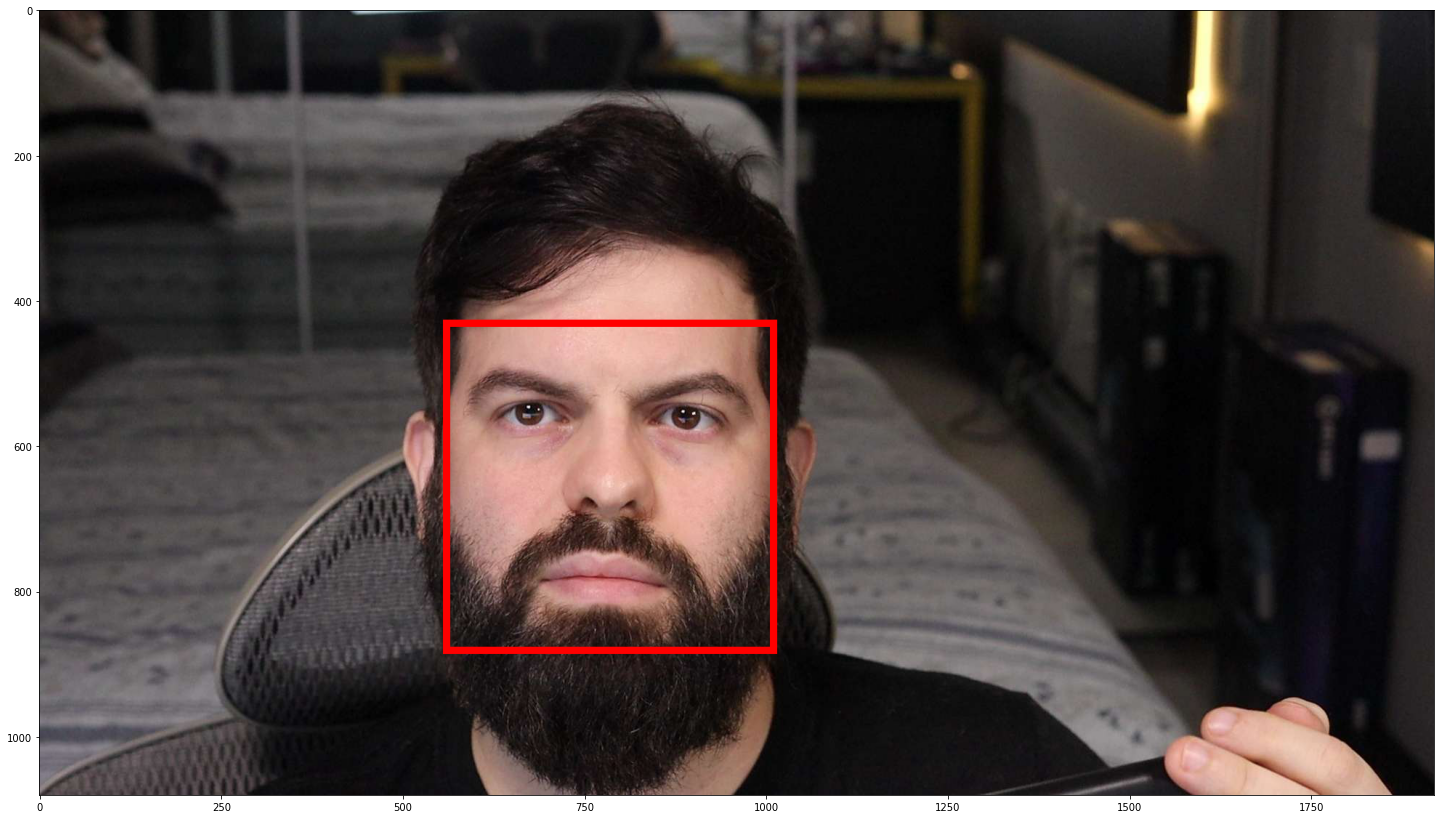

In [10]:
print_image("./photo.jpg","rectangle")

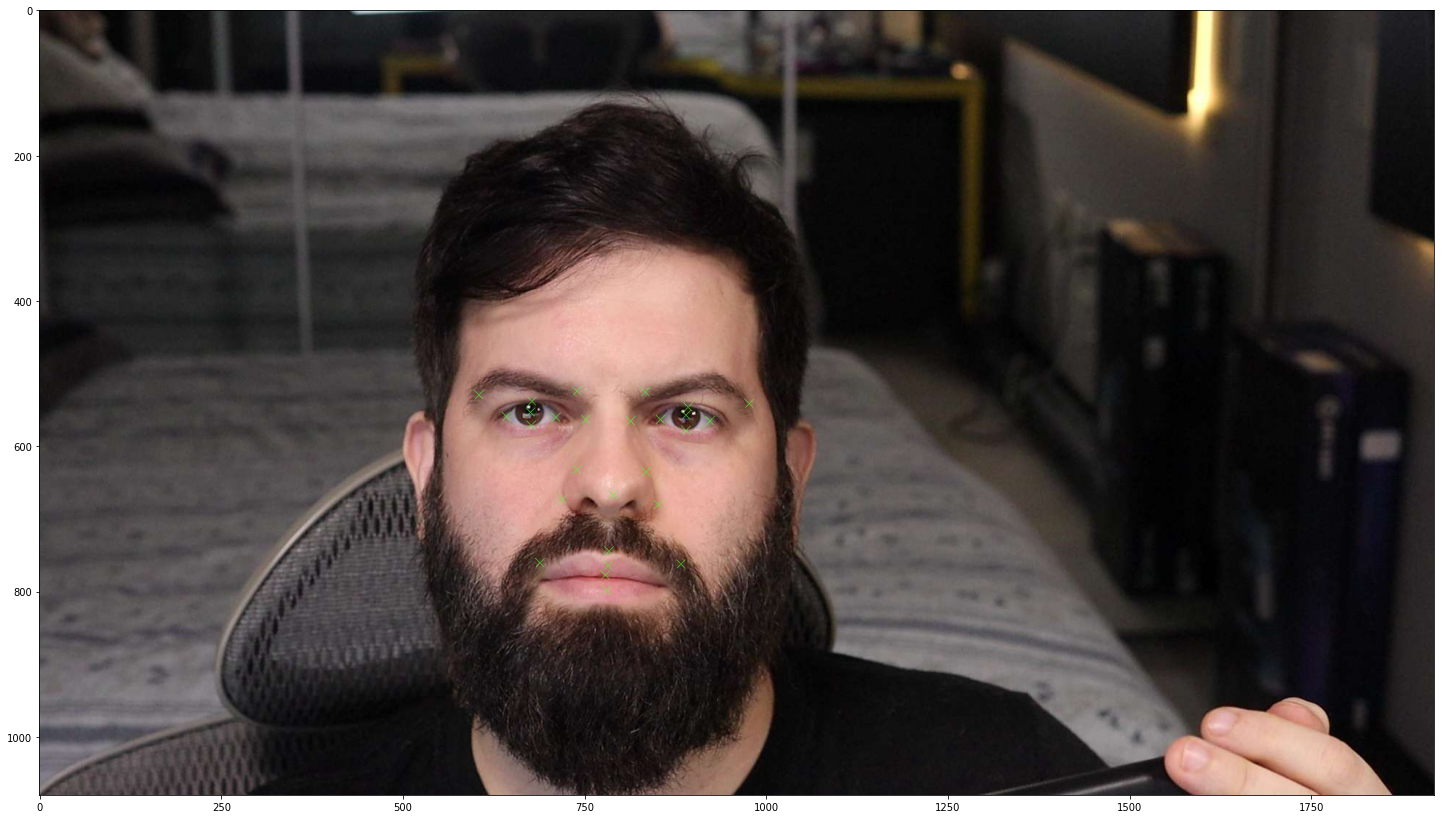

In [11]:
print_image("./photo.jpg","landmarks")

In [12]:
def conceder_emprestimo(photo, name, conteudo):
  if is_person(photo) and not_explicit(photo) and is_gender_age(photo,genero,idade) and not is_caloteiro(conteudo):
    print(f"\nResultado: Conceder empréstimo para {name}")
  else:
    print(f"\nResultado: Não conceder empréstimo para {name}\n\n")

In [13]:
VERBOSE = True
DEBUG = False

conceder_emprestimo("./photo.jpg",nome, perfil)
pd.read_json(perfil).head()

1. Pessoa detectada. Score: 76.50%
2. Imagem não explícita. Score: 99.90%
3. Genero:
   - informado Masculino
   - detectado: Masculino
   Idade:
   - informada 36
   - detectada: 38
4. Provável que honre com o pagamento.
   Probabilidade de calote Modelo 1: 0.24%
   Probabilidade de calote Modelo 2: 0.73%

Resultado: Conceder empréstimo para Fabio Rizzi


,nome,renda,idade,etnia,sexo,casapropria,outrasrendas,escolaridade
0,Fabio Rizzi,10000,36,0,0,0,1,1


https://youtu.be/_8M_r707MCU